# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [34]:
# Your code here.
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor, Resize, Compose
import torch
from tqdm import tqdm
import wandb
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class CIFAR100_wrapper(Dataset):

    def __init__(self, classes: set[int], get_train: bool = True) -> None:
        super().__init__()
        self.classes = classes
        cifar = CIFAR100("~/datasets", download=get_train, train=get_train, transform=Compose([ToTensor()]))
        samples = []
        labels = []
        for i in range(len(cifar)):
            if cifar[i][1] in classes:
                samples.append(cifar[i][0])
                labels.append(torch.Tensor([cifar[i][1]]).long())
        self.data = torch.stack(samples)
        self.labels = torch.cat(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]: return self.data[index], self.labels[index]

index_id = set(range(20))
index_ood = set(range(30, 40))

batch_size=64

c20 = CIFAR100_wrapper(index_id)
c20_train, c20_val = random_split(c20, [0.7, 0.3])
c20_test = CIFAR100_wrapper(index_id)
c20_ood = CIFAR100_wrapper(index_ood)
dl_train = DataLoader(c20_train, batch_size, shuffle=True)
dl_val = DataLoader(c20_val, batch_size, shuffle=True)
dl_test = DataLoader(c20_test, batch_size, shuffle=True)
dl_ood = DataLoader(c20_ood, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [42]:
@torch.no_grad()
def ood_test(model, dataloader):
    max_logits = []
    min_logits = []
    for x, _ in dataloader:
        x = x.to(device)
        logits = model(x)
        max_logits.append(logits.max(dim=1).values)
        min_logits.append(logits.min(dim=1).values)
    max_logits = torch.cat(max_logits)
    min_logits = torch.cat(min_logits)
    return max_logits # - min_logits

# Model
A simple model for classification

In [14]:
def conv_3x3_same_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU()
    )

def conv_3x3_valid_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
        nn.MaxPool2d(3, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(), 
        nn.Dropout(0.3)
    )

class RCNN(nn.Module): 
    def __init__(self, res, input_channels, embedding_filters, depth, n_classes) -> None:
        super(RCNN, self).__init__()
        self.input = nn.Sequential(*[
            conv_3x3_valid_block(input_channels, embedding_filters // 4), 
            conv_3x3_valid_block(embedding_filters // 4, embedding_filters // 2), 
            conv_3x3_valid_block(embedding_filters // 2, embedding_filters)
        ])
        self.net = nn.ModuleList([
            conv_3x3_same_block(embedding_filters, embedding_filters)
        for _ in range(depth)])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(((res - 12) ** 2) * embedding_filters, n_classes)
        )
    def forward(self, X):
        X = self.input(X)
        for layer in self.net:
            X = X + layer(X)
        return self.out(X)

In [15]:
import torch.nn as nn
class SimpleCNN(nn.Module):

    def __init__(self, res, input_channels, embedding_channels, n_convs, n_classes) -> None:
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(input_channels, embedding_channels, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(3, stride=1))
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Conv2d(embedding_channels, embedding_channels, kernel_size=3, padding=1), nn.LayerNorm((embedding_channels, res-2, res-2)), nn.ReLU())
        ], nn.MaxPool2d(3, stride=1))
        self.head = nn.Linear(((res-4)**2) * embedding_channels, n_classes)

    def forward(self, X):
        X = self.input(X)
        X = self.net(X)
        return self.head(X.flatten(1))

In [16]:
from torchvision.models import AlexNet
resolution = 32
channels = 3
embedding_channels = 64
n_blocks = 20
n_classes = 20
model = SimpleCNN(resolution, channels, embedding_channels, n_blocks, n_classes).to(device)
x = torch.rand((16, 3, 32, 32)).to(device)
model(x).shape

torch.Size([16, 20])

## Training

In [17]:
@torch.no_grad()
def validation(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

In [18]:
def training(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [19]:
loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
lss, accs = training(model, dl_train, dl_val, loss_fn, optim, 200, 5, False)

Loss Train = 2.326447703621604, Loss Val = 2.3673661617522543, Acc = 0.30933333333333335


Loss Train = 1.6395447600971569, Loss Val = 1.7776301414408582, Acc = 0.4623333333333333


Loss Train = 1.6652819156646728, Loss Val = 1.8619571974936953, Acc = 0.4693333333333333


Loss Train = 1.9067785317247563, Loss Val = 1.9325206533391426, Acc = 0.413


Loss Train = 1.7934125477617437, Loss Val = 1.8891087795825714, Acc = 0.4266666666666667


Loss Train = 1.7593742002140391, Loss Val = 1.793710267290156, Acc = 0.44766666666666666


Loss Train = 1.756436906077645, Loss Val = 1.8281307068276913, Acc = 0.437


Loss Train = 1.7399972893974998, Loss Val = 1.8791629405731851, Acc = 0.429


Loss Train = 1.7166465910998259, Loss Val = 1.8256438793020044, Acc = 0.44666666666666666


Loss Train = 1.7145705168897456, Loss Val = 1.83787653801289, Acc = 0.439


Loss Train = 1.7310924237424676, Loss Val = 1.840467371839158, Acc = 0.43733333333333335


Loss Train = 1.7116694060238924, Loss Val = 1.7647383745680465, Acc = 0.46366666666666667


Loss Train = 1.7090487783605401, Loss Val = 1.8112340328541208, Acc = 0.43966666666666665


Loss Train = 1.7127174659208817, Loss Val = 1.8185178903823203, Acc = 0.447


Loss Train = 1.7106963005932894, Loss Val = 1.8107785138678043, Acc = 0.43666666666666665


Loss Train = 1.6999467578801242, Loss Val = 1.7709090735049957, Acc = 0.46166666666666667


Loss Train = 1.6990446849302812, Loss Val = 1.7973063271096412, Acc = 0.43466666666666665


Loss Train = 1.6828467347405174, Loss Val = 1.7854043118497158, Acc = 0.44966666666666666


Loss Train = 1.6890723748640581, Loss Val = 1.8072772178244083, Acc = 0.45066666666666666


Loss Train = 1.6898827119307085, Loss Val = 1.8120298182710688, Acc = 0.43833333333333335


Loss Train = 1.6847385959191756, Loss Val = 1.858607068974921, Acc = 0.43066666666666664


Loss Train = 1.6723061789165843, Loss Val = 1.7917688856733607, Acc = 0.44433333333333336


Loss Train = 1.6778170986609025, Loss Val = 1.787755750595255, Acc = 0.4543333333333333


Loss Train = 1.6864155769348144, Loss Val = 1.759767621121508, Acc = 0.46066666666666667


Loss Train = 1.6687078096649863, Loss Val = 1.7540675553869693, Acc = 0.462


Loss Train = 1.6929803501475942, Loss Val = 1.8012000398432955, Acc = 0.43933333333333335


Loss Train = 1.6766281919045882, Loss Val = 1.791586919033781, Acc = 0.442


Loss Train = 1.6684652415188876, Loss Val = 1.784250411581486, Acc = 0.459


Loss Train = 1.6770201899788597, Loss Val = 1.7775721499260435, Acc = 0.4533333333333333


Loss Train = 1.6981444564732637, Loss Val = 1.7651108833069498, Acc = 0.466


Loss Train = 1.6842309745875272, Loss Val = 1.7732530730835936, Acc = 0.4643333333333333


Loss Train = 1.6696943228895014, Loss Val = 1.803094265308786, Acc = 0.44233333333333336


Loss Train = 1.6796668995510449, Loss Val = 1.7593602018153414, Acc = 0.4656666666666667


Loss Train = 1.6815974625674162, Loss Val = 1.7915170344900577, Acc = 0.44533333333333336


Loss Train = 1.684450143033808, Loss Val = 1.787905954300089, Acc = 0.447


Loss Train = 1.7025818196209994, Loss Val = 1.8183554461661806, Acc = 0.44


Loss Train = 1.6947459643537348, Loss Val = 1.7753539592661756, Acc = 0.44433333333333336


Loss Train = 1.6699374946680936, Loss Val = 1.7491862773895264, Acc = 0.45966666666666667


Loss Train = 1.6661482962695036, Loss Val = 1.7817752361297607, Acc = 0.45


Loss Train = 1.6783833807164972, Loss Val = 1.7528016871594367, Acc = 0.462


In [43]:
id_data = ood_test(model, dl_test)
ood_data = ood_test(model, dl_ood)

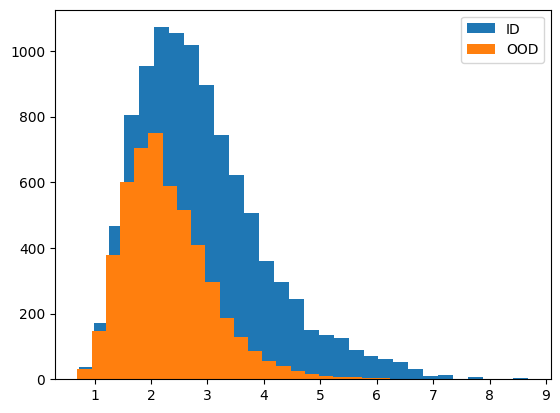

In [44]:
plt.hist(id_data.cpu(), bins=30, label="ID")
plt.hist(ood_data.cpu(), bins=30, label="OOD")
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [3]:
# Your code here.

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [4]:
# Your code here.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
